In [1]:
# !pip install yfinance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

stock_filepath = os.getenv('HOME') +'/aiffel/aiffel_quest/mini_quest_240229/data/'
df = pd.read_csv(stock_filepath + '005930.KS.csv')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
1,2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2,2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
3,2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
4,2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [2]:
df = pd.read_csv(stock_filepath + '005930.KS.csv', index_col='Date', parse_dates=True)

ts_close =df['Close']
ts_close.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

### 시계열 안정성 정성적 분석

In [3]:
ts_close = ts_close.interpolate(method='time')
ts_close[ts_close.isna()]

Series([], Name: Close, dtype: float64)

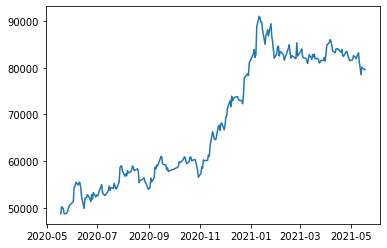

In [4]:
plt.plot(ts_close)

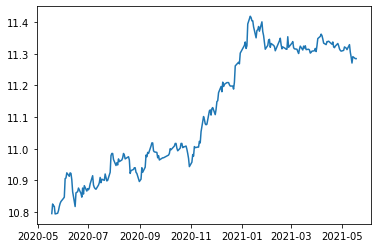

In [5]:
ts_log = np.log(ts_close)
plt.plot(ts_log)

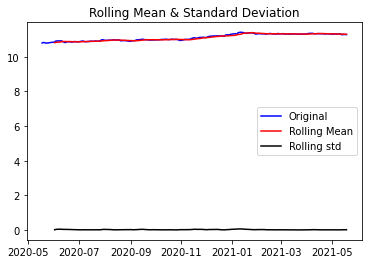

Results of Dickey=Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


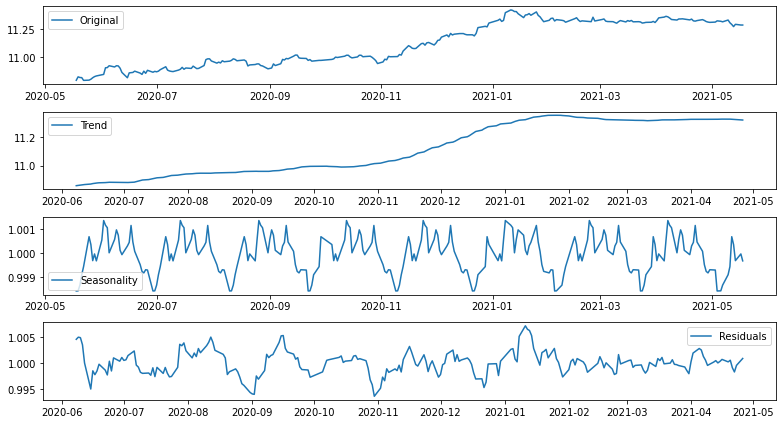

In [6]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)



from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    
    print('Results of Dickey=Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)


#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 


plt.rcParams['figure.figsize'] = (11,6)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

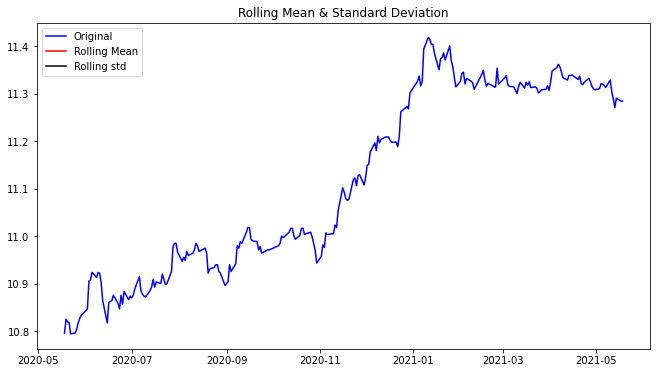

In [7]:
plot_rolling_statistics(ts_log, window=365)

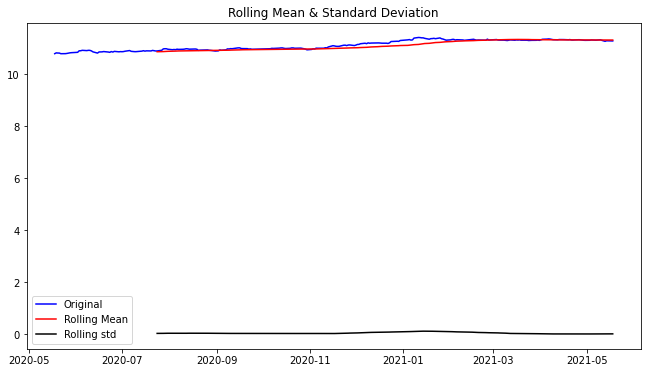

In [8]:
plot_rolling_statistics(ts_log, window=50)

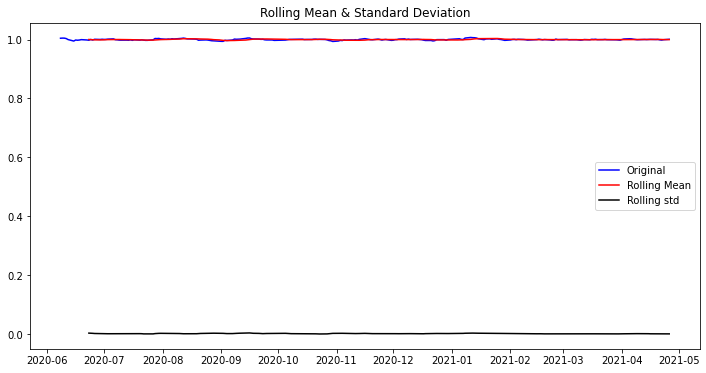

In [9]:
# Residual 안정성 확인
# [[YOUR CODE]]
residual.dropna(inplace=True)
plt.rcParams['figure.figsize'] = (12, 6)
plot_rolling_statistics(residual)

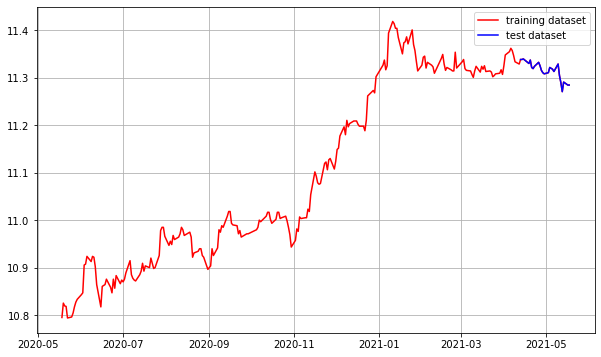

In [10]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

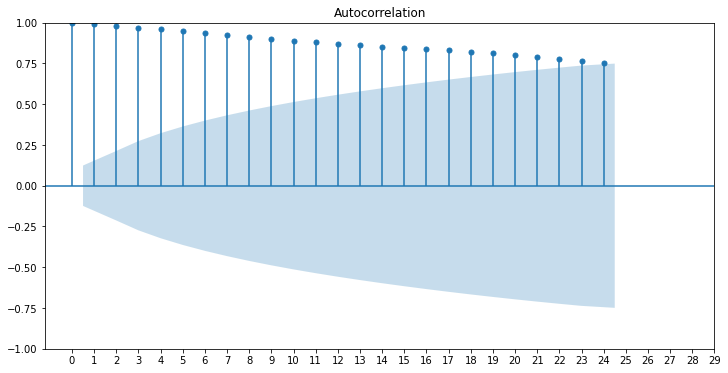

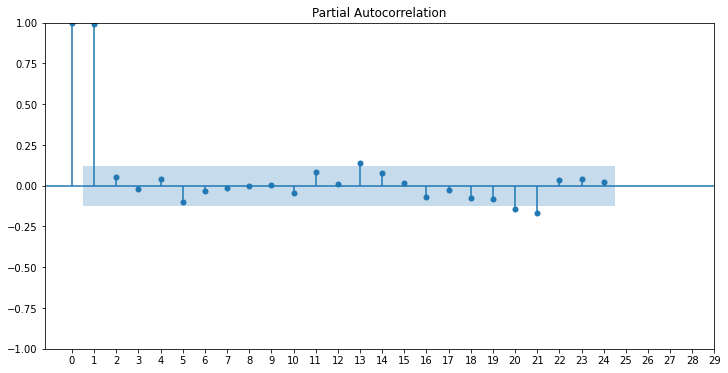

In [11]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(ts_log)
plt.xticks(range(0, 30, 1))
plot_pacf(ts_log)
plt.xticks(range(0, 30, 1))
plt.show()

Results of Dickey=Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey=Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


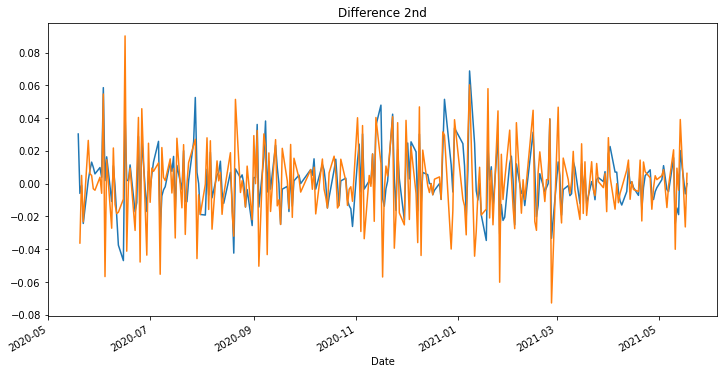

In [12]:
# 차분 안정성 확인 -> d 구하기

diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)


# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### 추세 상쇄하기

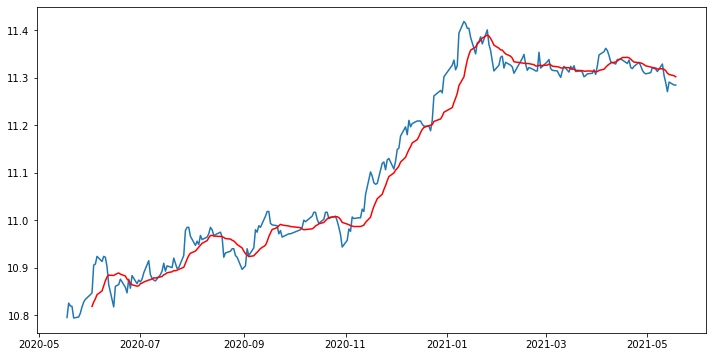

In [13]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [14]:
ts_log_moving_avg = ts_log - moving_avg
ts_log_moving_avg.head(20)

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22         NaN
2020-05-25         NaN
2020-05-26         NaN
2020-05-27         NaN
2020-05-28         NaN
2020-05-29         NaN
2020-06-01         NaN
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
2020-06-08    0.061862
2020-06-09    0.061925
2020-06-10    0.049636
2020-06-11    0.021446
2020-06-12   -0.019996
Name: Close, dtype: float64

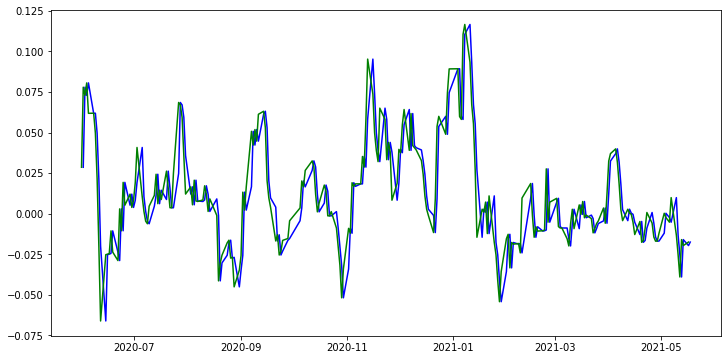

In [15]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)


plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

In [16]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(20)

Date
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
2020-06-08    0.061862
2020-06-09    0.061925
2020-06-10    0.049636
2020-06-11    0.021446
2020-06-12   -0.019996
2020-06-15   -0.066141
2020-06-16   -0.025267
2020-06-17   -0.024961
2020-06-18   -0.024494
2020-06-19   -0.010603
2020-06-22   -0.023697
2020-06-23   -0.028907
2020-06-24    0.002950
2020-06-25   -0.010546
2020-06-26    0.019292
2020-06-29    0.005231
Name: Close, dtype: float64

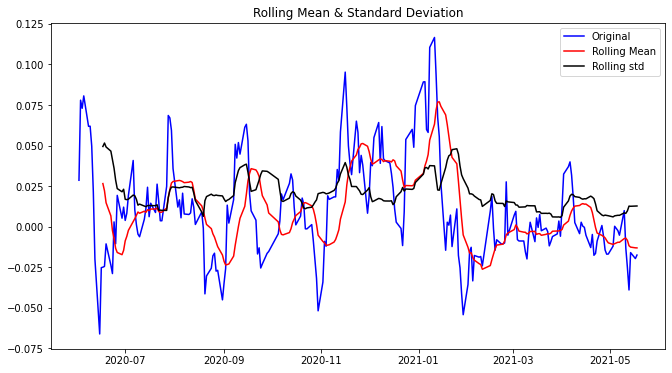

In [25]:
plot_rolling_statistics(ts_log_moving_avg)

In [26]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey=Fuller Test:
Test Statistic                  -4.163469
p-value                          0.000759
#Lags Used                       0.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


In [27]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

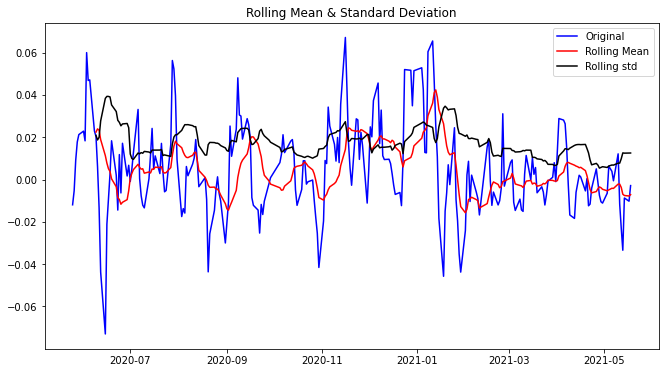

In [28]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [29]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey=Fuller Test:
Test Statistic                  -4.800754
p-value                          0.000054
#Lags Used                       5.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


In [ ]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

In [13]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 29 Feb 2024   AIC                          -1156.722
Time:                        10:22:12   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

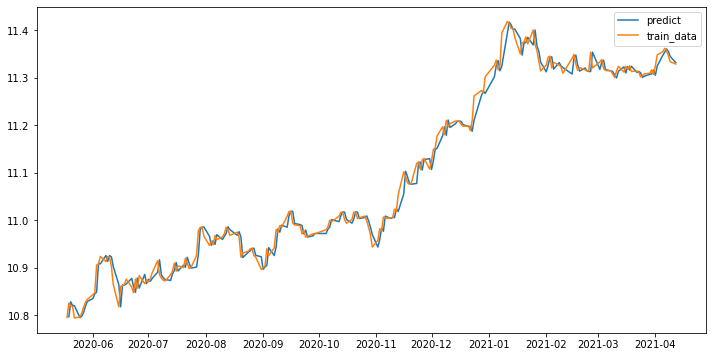

In [14]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given

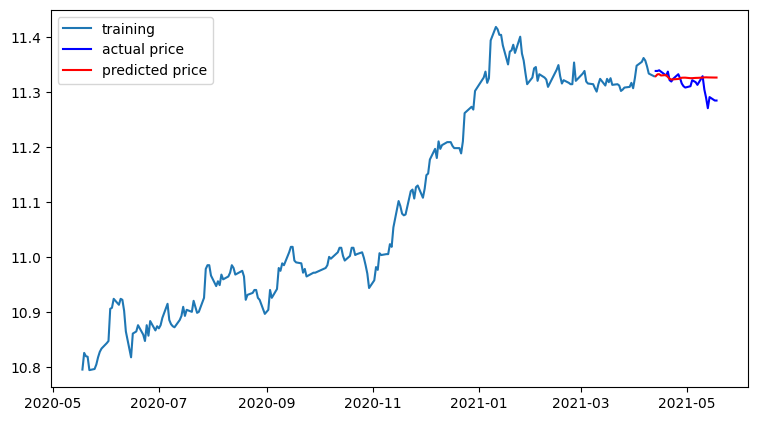

In [15]:
model = ARIMA(train_data, order=(14,1,0))
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3005069.905300547
MAE:  1233.7924909538601
RMSE:  1733.5137453451434
MAPE: 1.53%


### 삼성주가 

In [18]:
import yfinance as yf

# 삼성전자 주식 데이터 불러오기
samsung_electronics = yf.Ticker('005930.KS')  # '005930.KS'는 삼성전자의 종목 코드입니다. '.KS'는 한국 시장을 의미합니다.

# 시작일과 종료일 설정 (2020년 1월 1일부터 2024년 1월 31일까지)
start_date = '2000-01-01'
end_date = '2024-02-27'

# 데이터 가져오기 (과거부터 오늘까지의 데이터)
samsung_data = samsung_electronics.history(start=start_date, end=end_date)


# 날짜 형식 변경 및 인덱스 설정
samsung_data.index = pd.to_datetime(samsung_data.index).strftime('%Y-%m-%d')

# 데이터프레임 생성
df = pd.DataFrame(samsung_data,  columns=samsung_data.columns)

df


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-04,4389.458240,4469.931641,4140.722273,4469.931641,74195000,0.0,0.0
2000-01-05,4243.143096,4433.352959,4038.301705,4082.196289,74680000,0.0,0.0
2000-01-06,4206.563408,4228.510695,4082.195446,4111.458496,54390000,0.0,0.0
2000-01-07,4067.563653,4148.037034,3921.248414,4052.932129,40305000,0.0,0.0
2000-01-10,4096.828761,4221.196777,4082.197230,4221.196777,46880000,0.0,0.0
...,...,...,...,...,...,...,...
2024-02-20,73700.000000,73700.000000,72800.000000,73300.000000,14681477,0.0,0.0
2024-02-21,73400.000000,73700.000000,72900.000000,73000.000000,11503495,0.0,0.0
2024-02-22,73800.000000,73900.000000,72700.000000,73100.000000,15208934,0.0,0.0


In [19]:
ts = df['Close']
ts

Date
2000-01-04     4469.931641
2000-01-05     4082.196289
2000-01-06     4111.458496
2000-01-07     4052.932129
2000-01-10     4221.196777
                  ...     
2024-02-20    73300.000000
2024-02-21    73000.000000
2024-02-22    73100.000000
2024-02-23    72900.000000
2024-02-26    72800.000000
Name: Close, Length: 6055, dtype: float64

In [20]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

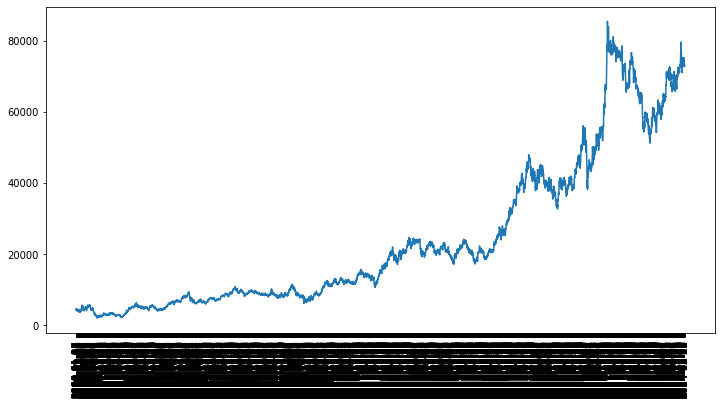

In [21]:
plt.plot(ts)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

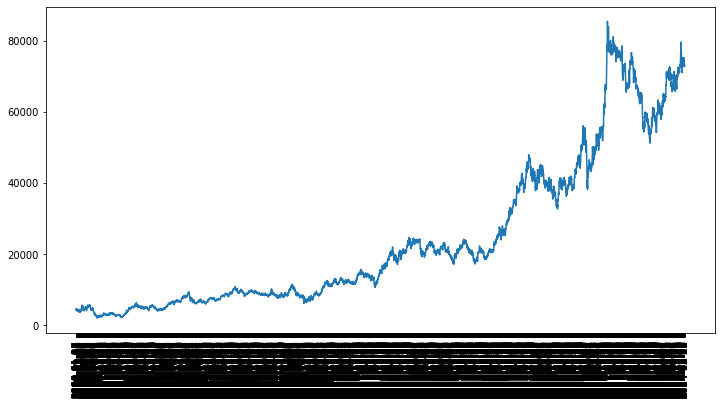

In [22]:
ts_log = np.log(ts)
plt.plot(ts)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

In [23]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [24]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    
    print('Results of Dickey=Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

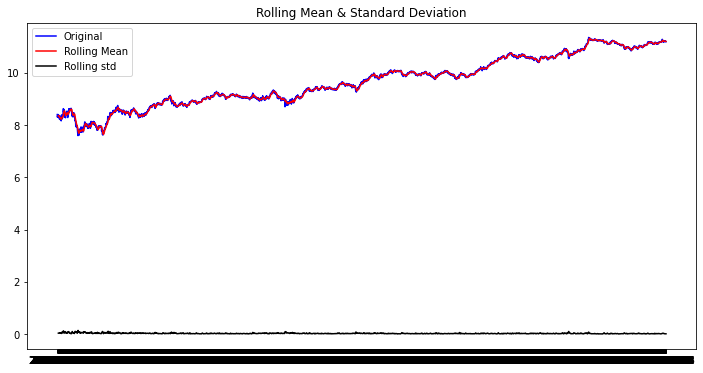

Results of Dickey=Fuller Test:
Test Statistic                   -0.591387
p-value                           0.872916
#Lags Used                        4.000000
Number of Observations Used    6050.000000
Critical Value (1%)              -3.431431
Critical Value (5%)              -2.862018
Critical Value (10%)             -2.567024
dtype: float64


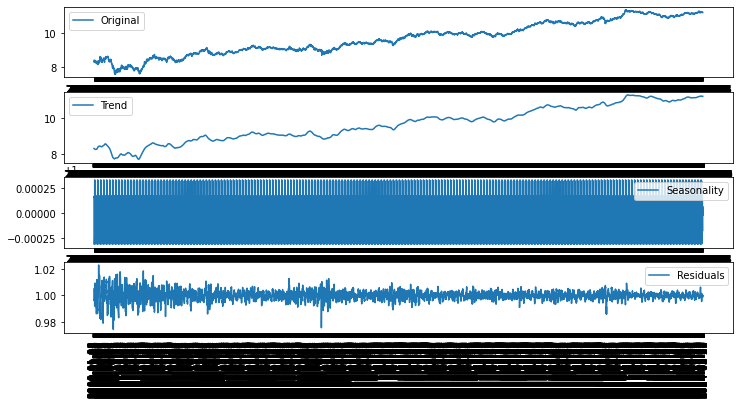

<Figure size 864x432 with 0 Axes>

In [25]:
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 
from statsmodels.tsa.seasonal import seasonal_decompose
decompostition = seasonal_decompose(ts_log, model='multiplicative', period=30)

trend = decompostition.trend
seasonal = decompostition.seasonal
residual = decompostition.resid



plt.rcParams['figure.figsize'] = (12,6)

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.xticks(rotation=90)

plt.show()

plt.tight_layout()


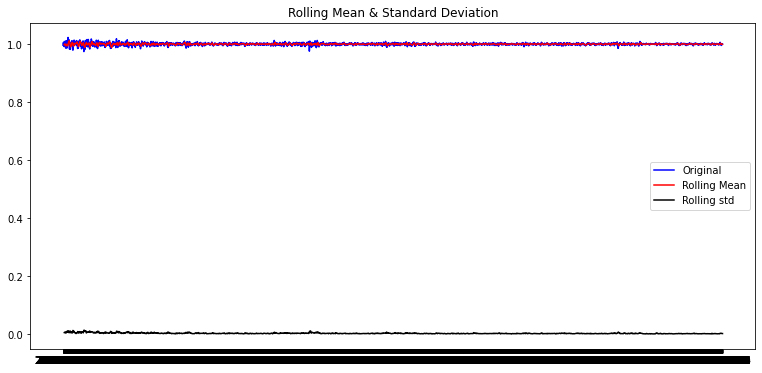

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

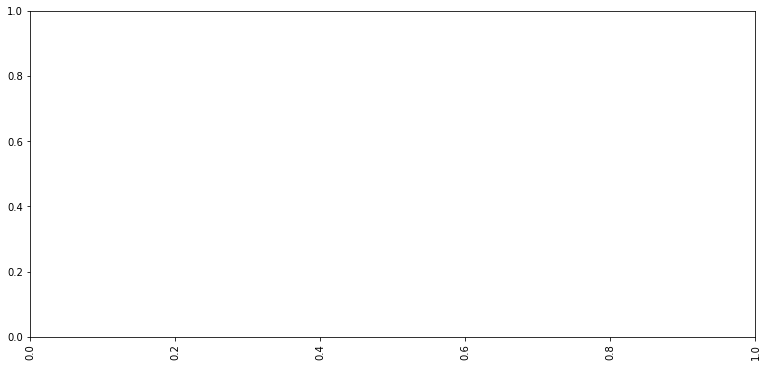

In [26]:
residual.dropna(inplace=True)
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)

In [27]:
ts_log[:int(len(ts_log))]

Date
2000-01-04     8.405128
2000-01-05     8.314390
2000-01-06     8.321533
2000-01-07     8.307196
2000-01-10     8.347874
                ...    
2024-02-20    11.202316
2024-02-21    11.198215
2024-02-22    11.199584
2024-02-23    11.196844
2024-02-26    11.195471
Name: Close, Length: 6055, dtype: float64

In [28]:
ts_log[int(len(ts_log)*0.9):]

Date
2021-09-06    11.201177
2021-09-07    11.185532
2021-09-08    11.188156
2021-09-09    11.174964
2021-09-10    11.174964
                ...    
2024-02-20    11.202316
2024-02-21    11.198215
2024-02-22    11.199584
2024-02-23    11.196844
2024-02-26    11.195471
Name: Close, Length: 606, dtype: float64

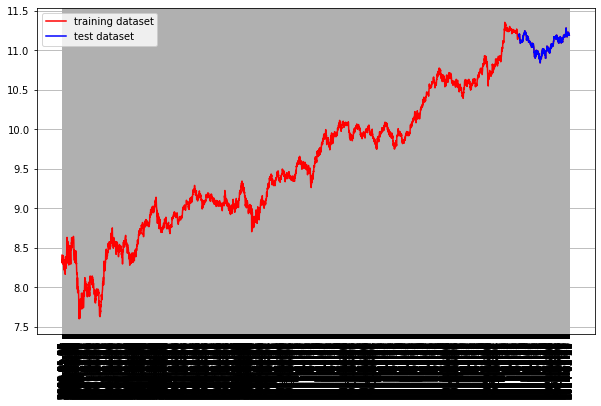

In [29]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.xticks(rotation=90)
plt.legend()

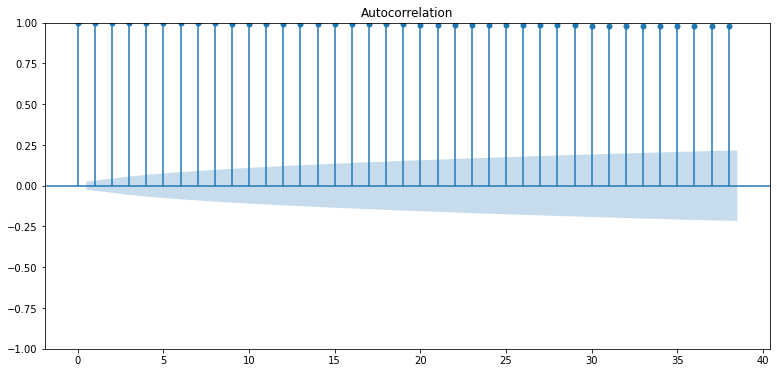

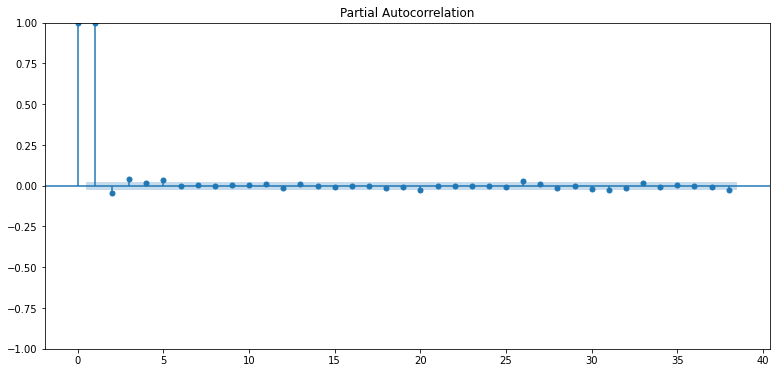

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

<AxesSubplot:title={'center':'Difference 1st'}, xlabel='Date'>

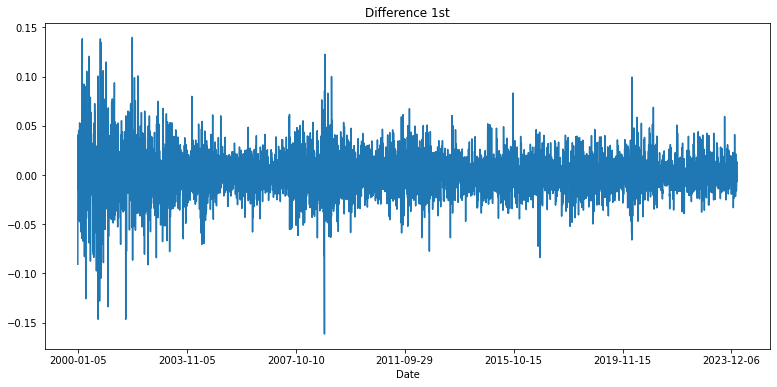

In [31]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

Results of Dickey=Fuller Test:
Test Statistic                  -22.955016
p-value                           0.000000
#Lags Used                       34.000000
Number of Observations Used    6018.000000
Critical Value (1%)              -3.431437
Critical Value (5%)              -2.862020
Critical Value (10%)             -2.567026
dtype: float64


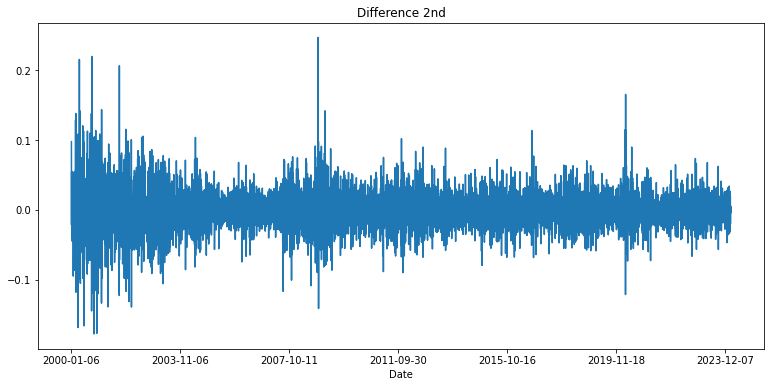

In [32]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

Results of Dickey=Fuller Test:
Test Statistic                  -29.856703
p-value                           0.000000
#Lags Used                       34.000000
Number of Observations Used    6017.000000
Critical Value (1%)              -3.431437
Critical Value (5%)              -2.862020
Critical Value (10%)             -2.567026
dtype: float64


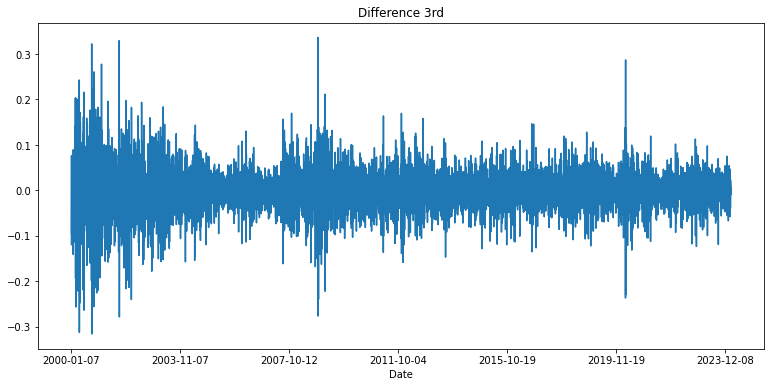

In [33]:
diff_3 = diff_2.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 3rd')

augmented_dickey_fuller_test(diff_3)

<AxesSubplot:title={'center':'Difference 2nd'}, xlabel='Date'>

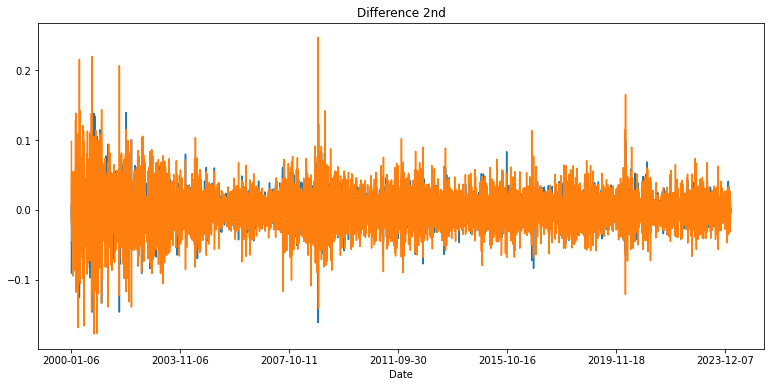

In [34]:
diff_1.plot(title='Difference 1st')
diff_2.plot(title='Difference 2nd')

ARIMA의 모수는 3가지

- p : 자기회귀 모형(AR)의 시차
- d : 차분 누적(I) 횟수
- q : 이동평균 모형(MA)의 시차

In [35]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5449
Model:                 ARIMA(2, 0, 1)   Log Likelihood               12986.371
Date:                Thu, 29 Feb 2024   AIC                         -25962.741
Time:                        10:32:23   BIC                         -25929.725
Sample:                             0   HQIC                        -25951.220
                               - 5449                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5161      0.654     14.547      0.000       8.234      10.798
ar.L1          0.0248      0.017      1.486      0.137      -0.008       0.058
ar.L2          0.9745      0.017     58.366      0.0

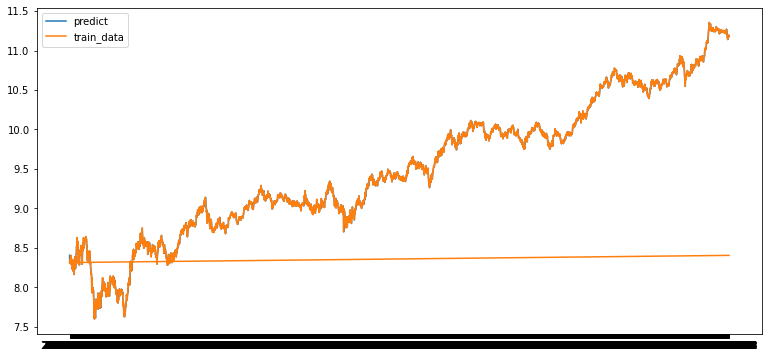

In [36]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given

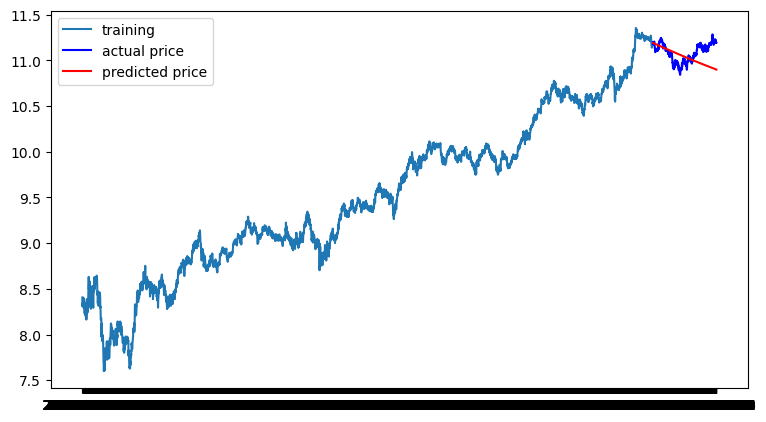

In [37]:
model = ARIMA(train_data, order=(2,0,1))
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

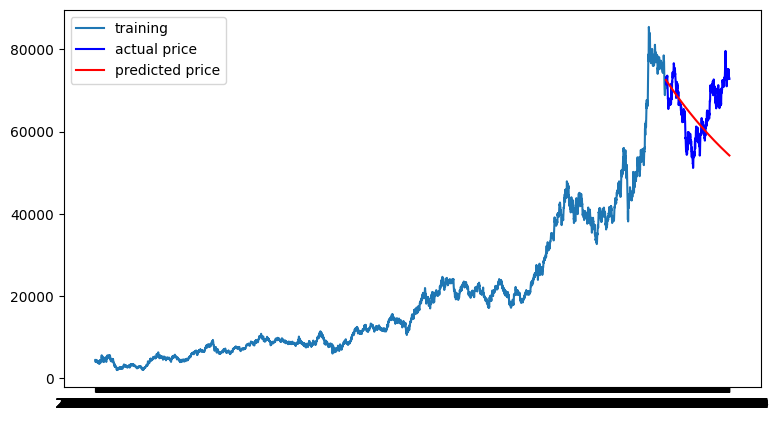

In [38]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  84397195.32915062
MAE:  7200.7663543025055
RMSE:  9186.794616684898
MAPE: 10.80%


## 아이온큐

In [96]:
import yfinance as yf

# 삼성전자 주식 데이터 불러오기
ionq = yf.Ticker('IONQ')  # '005930.KS'는 삼성전자의 종목 코드입니다. '.KS'는 한국 시장을 의미합니다.



# 데이터 가져오기 (과거부터 오늘까지의 데이터)
ionq_data = ionq.history(period='max')


# 날짜 형식 변경 및 인덱스 설정
ionq_data.index = pd.to_datetime(ionq_data.index).strftime('%Y-%m-%d')

# 데이터프레임 생성
df = pd.DataFrame(ionq_data,  columns=ionq_data.columns)

df


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-04,11.125,11.250,10.50,10.80,150500,0.0,0.0
2021-01-05,10.850,11.830,10.75,11.11,165300,0.0,0.0
2021-01-06,11.500,11.500,11.00,11.05,175600,0.0,0.0
2021-01-07,11.500,11.500,11.05,11.11,94200,0.0,0.0
2021-01-08,11.650,12.350,11.00,11.01,137500,0.0,0.0
...,...,...,...,...,...,...,...
2024-02-22,10.910,11.165,10.76,10.99,5899600,0.0,0.0
2024-02-23,11.110,11.120,10.53,10.65,4673000,0.0,0.0
2024-02-26,10.820,11.300,10.77,11.24,6379300,0.0,0.0


In [97]:
ts = df['Close']
ts

Date
2021-01-04    10.80
2021-01-05    11.11
2021-01-06    11.05
2021-01-07    11.11
2021-01-08    11.01
              ...  
2024-02-22    10.99
2024-02-23    10.65
2024-02-26    11.24
2024-02-27    11.57
2024-02-28    11.26
Name: Close, Length: 793, dtype: float64

In [98]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

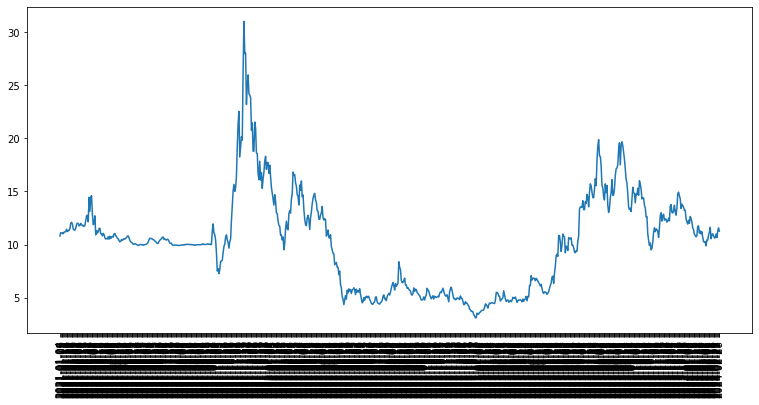

In [99]:
plt.plot(ts)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

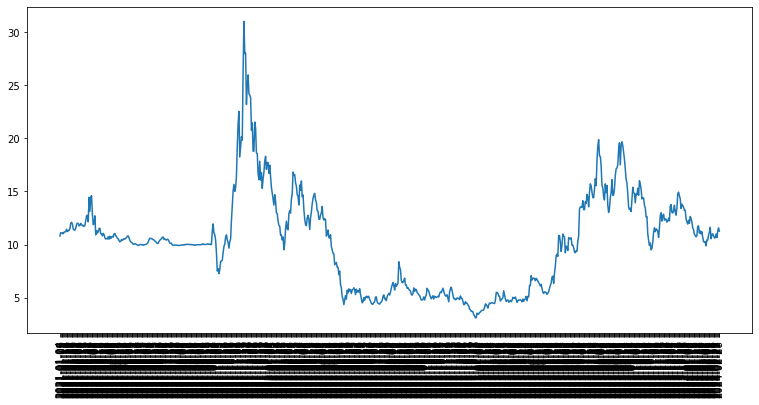

In [100]:
ts_log = np.log(ts)
plt.plot(ts)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

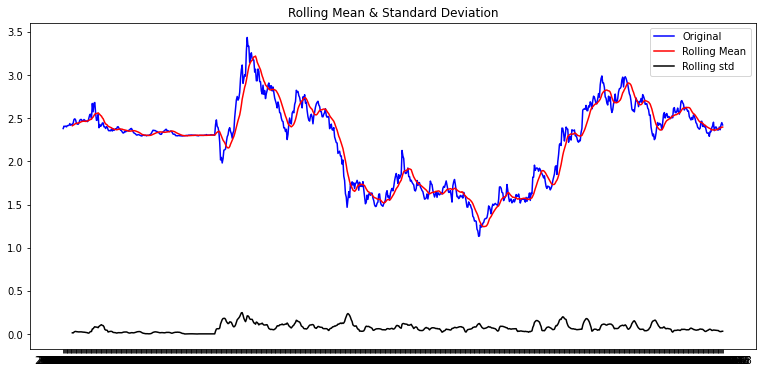

In [101]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

Results of Dickey=Fuller Test:
Test Statistic                  -1.815859
p-value                          0.372617
#Lags Used                      16.000000
Number of Observations Used    776.000000
Critical Value (1%)             -3.438805
Critical Value (5%)             -2.865272
Critical Value (10%)            -2.568757
dtype: float64


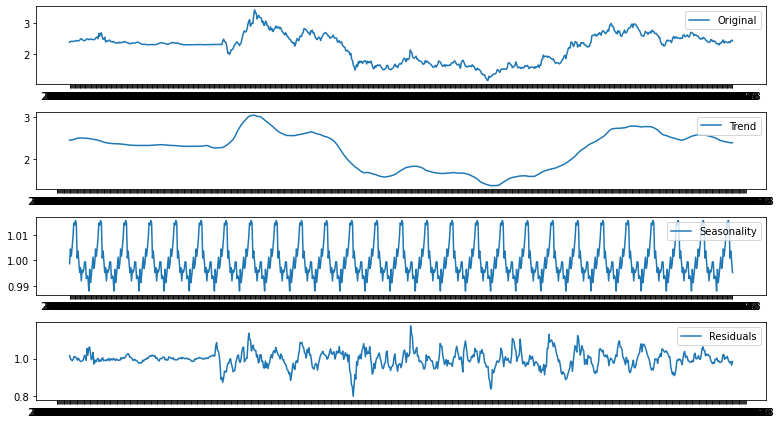

In [102]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 


plt.rcParams['figure.figsize'] = (11,6)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

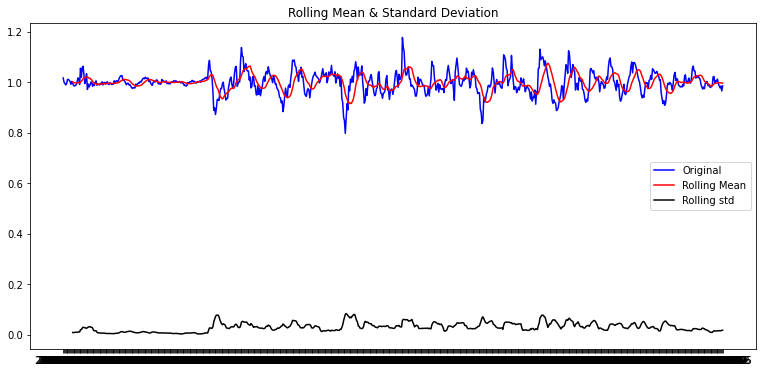

In [103]:
residual.dropna(inplace=True)
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)

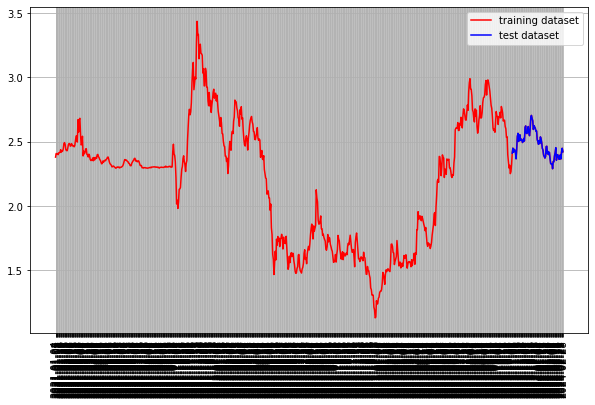

In [104]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.xticks(rotation=90)
plt.legend()

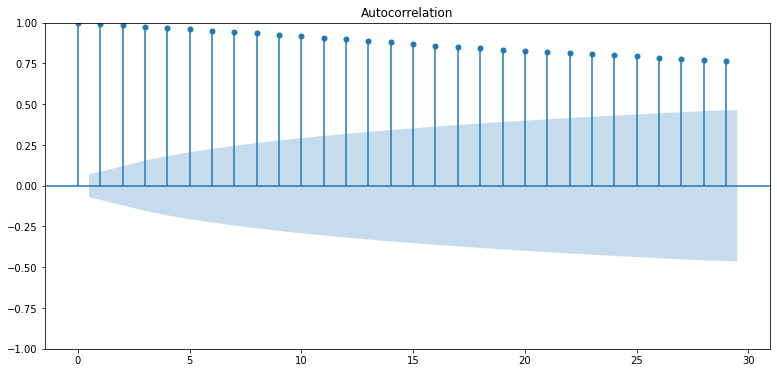

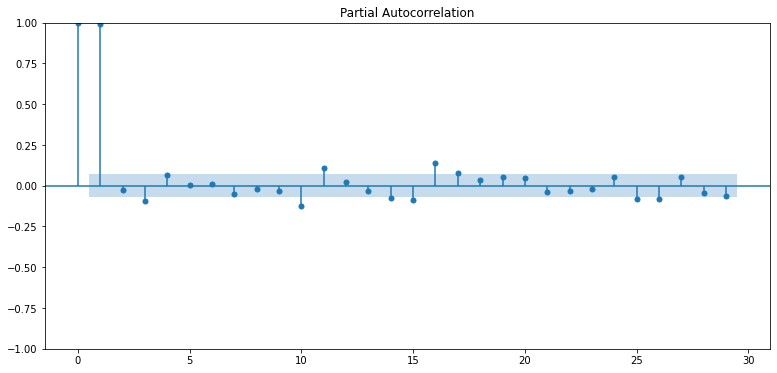

In [105]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

<AxesSubplot:title={'center':'Difference 1st'}, xlabel='Date'>

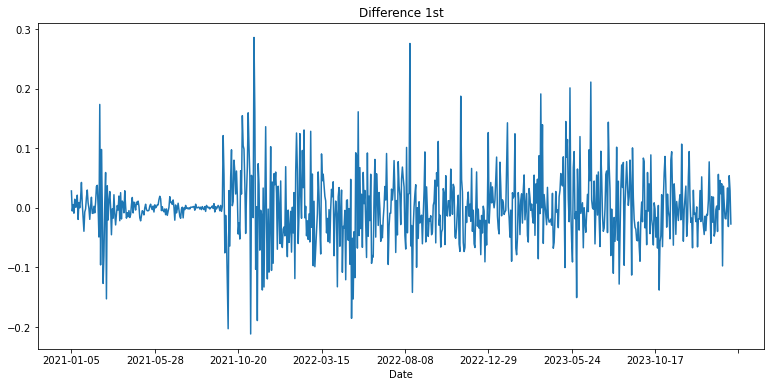

In [106]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
            

Results of Dickey=Fuller Test:
Test Statistic                -1.015437e+01
p-value                        7.799567e-18
#Lags Used                     2.000000e+01
Number of Observations Used    7.700000e+02
Critical Value (1%)           -3.438871e+00
Critical Value (5%)           -2.865301e+00
Critical Value (10%)          -2.568773e+00
dtype: float64


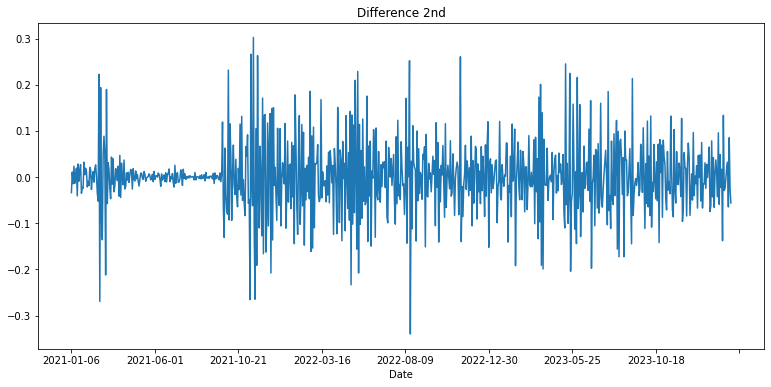

In [107]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

Results of Dickey=Fuller Test:
Test Statistic                -1.254033e+01
p-value                        2.322161e-23
#Lags Used                     2.000000e+01
Number of Observations Used    7.690000e+02
Critical Value (1%)           -3.438882e+00
Critical Value (5%)           -2.865306e+00
Critical Value (10%)          -2.568775e+00
dtype: float64


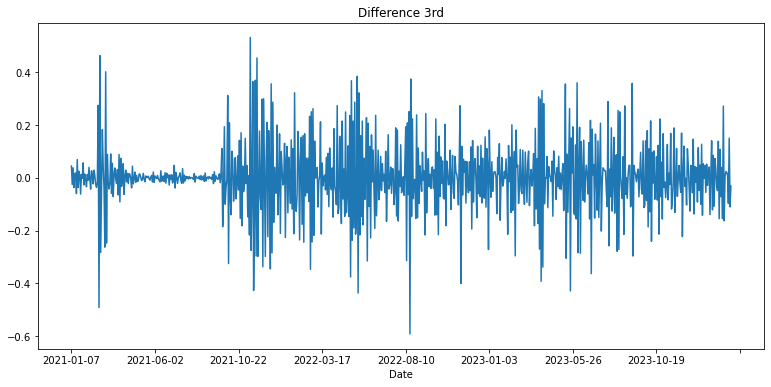

In [108]:
diff_3 = diff_2.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 3rd')

augmented_dickey_fuller_test(diff_3)

<AxesSubplot:title={'center':'Difference 3rd'}, xlabel='Date'>

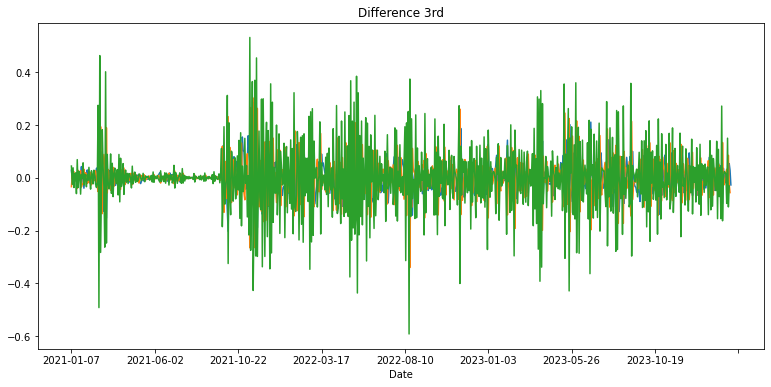

In [109]:
diff_1.plot(title='Difference 1st')
diff_2.plot(title='Difference 2nd')
diff_3.plot(title='Difference 3rd')


In [110]:
model = ARIMA(train_data, order=(5, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  713
Model:                 ARIMA(5, 0, 1)   Log Likelihood                1032.616
Date:                Thu, 29 Feb 2024   AIC                          -2049.232
Time:                        12:31:53   BIC                          -2012.677
Sample:                             0   HQIC                         -2035.113
                                - 713                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2285      0.244      9.152      0.000       1.751       2.706
ar.L1          0.7557      2.337      0.323      0.746      -3.824       5.335
ar.L2          0.3325      2.365      0.141      0.8

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


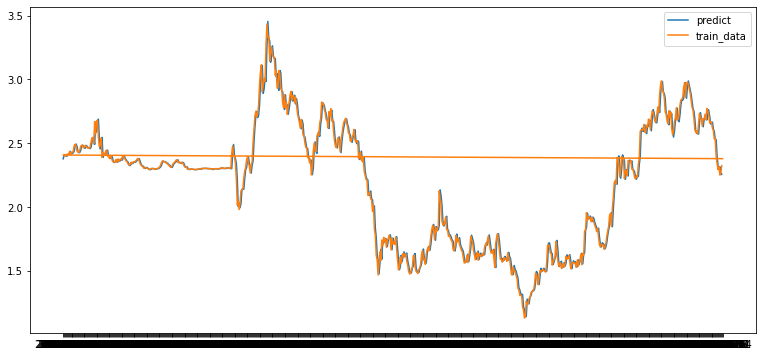

In [111]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

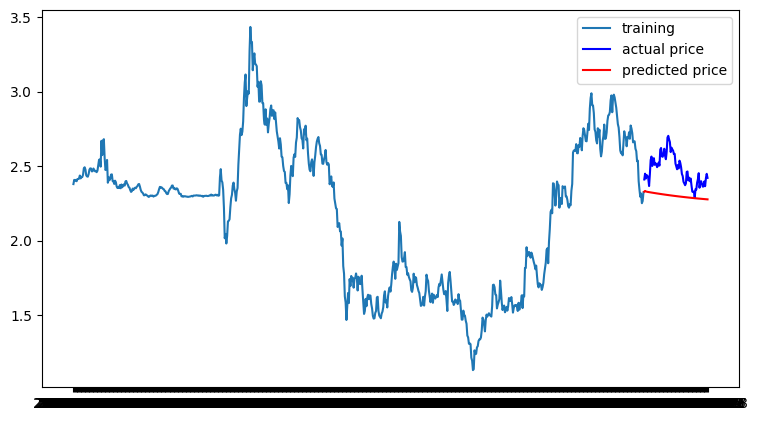

In [112]:
model = ARIMA(train_data, order=(5, 0, 1))  
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

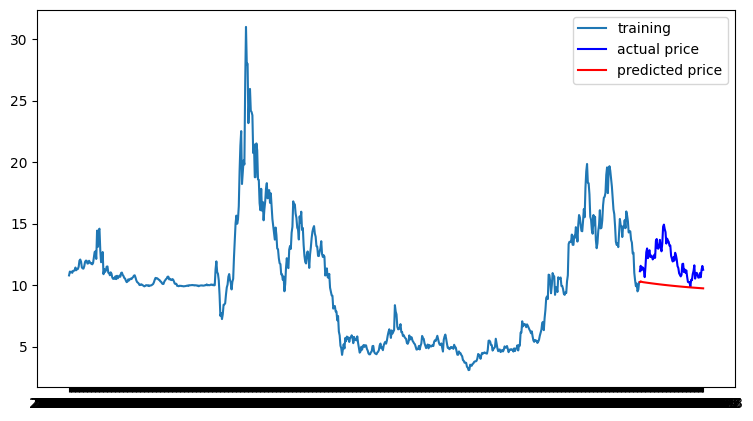

In [113]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [114]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  5.160211330510705
MAE:  1.9791468933433165
RMSE:  2.271609854378763
MAPE: 15.82%


## 코닝

In [115]:
import yfinance as yf

# 삼성전자 주식 데이터 불러오기
cornings = yf.Ticker('GLW')  # '005930.KS'는 삼성전자의 종목 코드입니다. '.KS'는 한국 시장을 의미합니다.



# 데이터 가져오기 (과거부터 오늘까지의 데이터)
cornings_data = cornings.history(period='max')


# 날짜 형식 변경 및 인덱스 설정
cornings_data.index = pd.to_datetime(cornings_data.index).strftime('%Y-%m-%d')

# 데이터프레임 생성
df = pd.DataFrame(cornings_data,  columns=cornings_data.columns)

df


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1981-12-31,0.798927,0.801818,0.796036,0.799890,674400,0.00,0.0
1982-01-04,0.803746,0.809528,0.796036,0.801818,914400,0.00,0.0
1982-01-05,0.796036,0.799891,0.792181,0.796036,876000,0.00,0.0
1982-01-06,0.786398,0.792181,0.778689,0.780616,770400,0.00,0.0
1982-01-07,0.763269,0.774834,0.749777,0.751705,1250400,0.00,0.0
...,...,...,...,...,...,...,...
2024-02-22,32.021121,32.437497,31.812935,32.407753,4716700,0.00,0.0
2024-02-23,32.487064,32.487064,32.179739,32.407753,2885300,0.00,0.0
2024-02-26,32.328448,32.487066,32.229309,32.229309,4089800,0.00,0.0


In [116]:
ts = df['Close']
ts

Date
1981-12-31     0.799890
1982-01-04     0.801818
1982-01-05     0.796036
1982-01-06     0.780616
1982-01-07     0.751705
                ...    
2024-02-22    32.407753
2024-02-23    32.407753
2024-02-26    32.229309
2024-02-27    32.150002
2024-02-28    32.090000
Name: Close, Length: 10628, dtype: float64

In [117]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

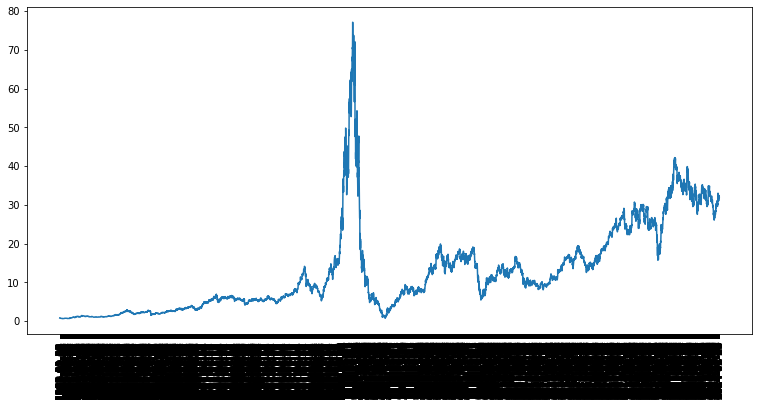

In [118]:
plt.plot(ts)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

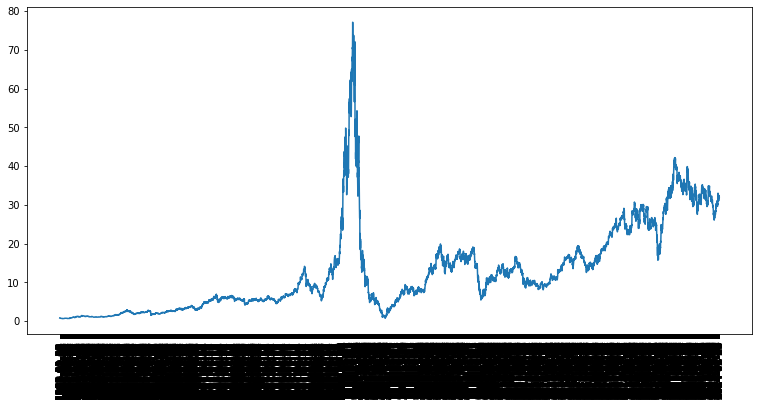

In [119]:
ts_log = np.log(ts)
plt.plot(ts)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

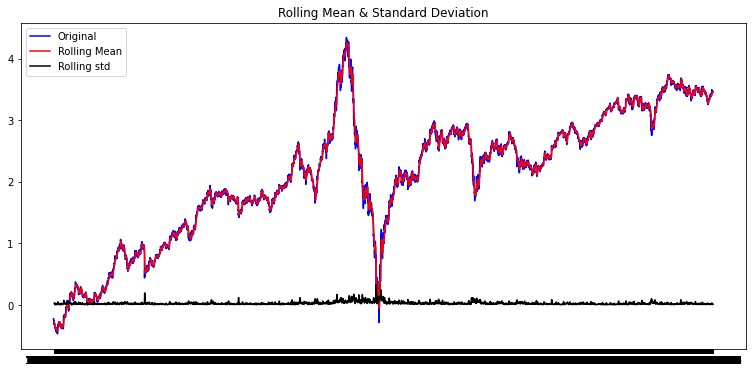

In [120]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

Results of Dickey=Fuller Test:
Test Statistic                    -2.190845
p-value                            0.209585
#Lags Used                        39.000000
Number of Observations Used    10588.000000
Critical Value (1%)               -3.430968
Critical Value (5%)               -2.861813
Critical Value (10%)              -2.566915
dtype: float64


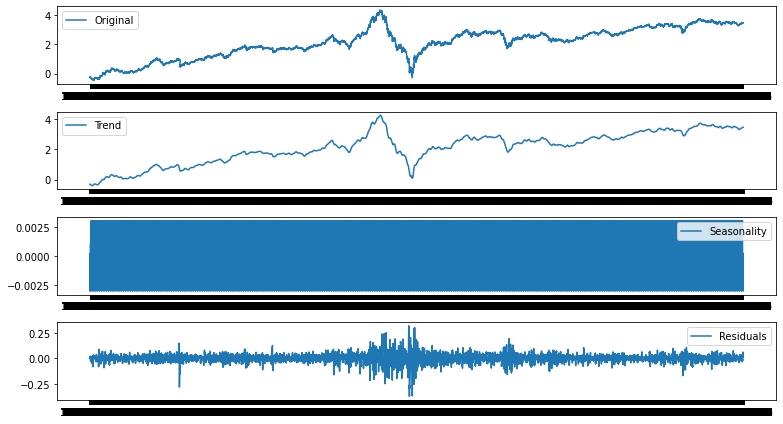

In [124]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

decomposition = seasonal_decompose(ts_log, model='additive', period = 30)
#시계열 데이터에 0 또는 음수 값이 있어서 발생한 오류이며, 이러한 값은 계절성을 곱하는 방법으로 분해할 수 없음


plt.rcParams['figure.figsize'] = (11,6)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

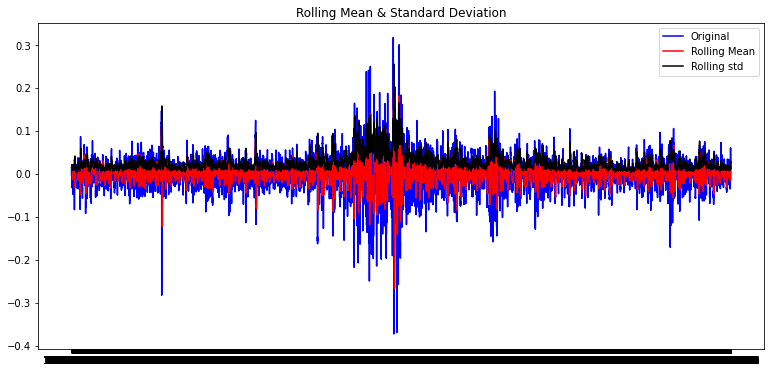

In [125]:
residual.dropna(inplace=True)
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)


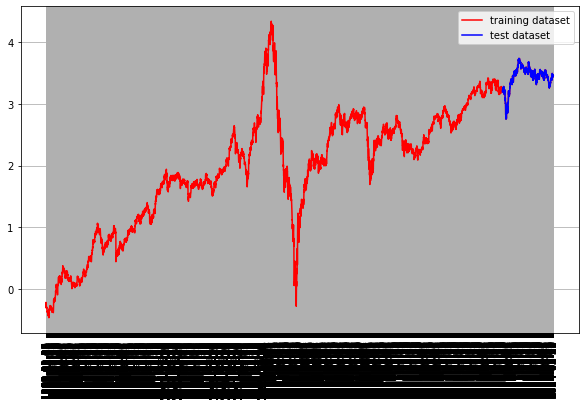

In [126]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.xticks(rotation=90)
plt.legend()

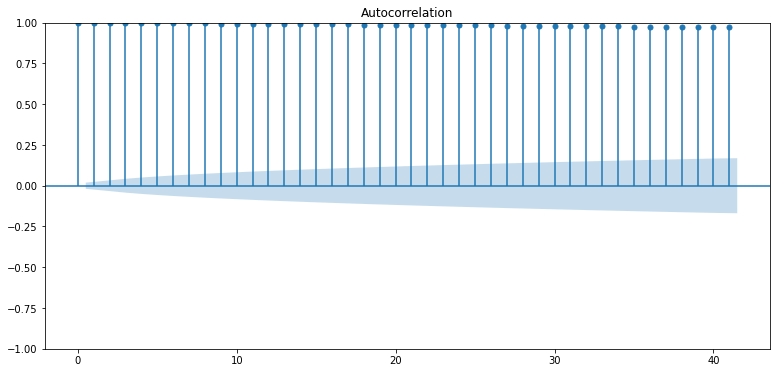

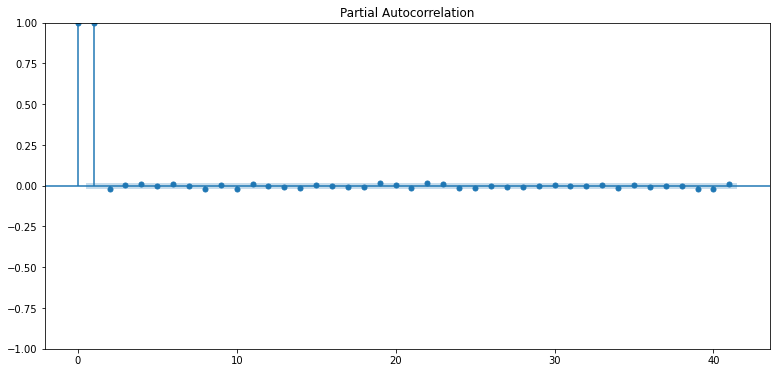

In [127]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey=Fuller Test:
Test Statistic                -1.487201e+01
p-value                        1.657903e-27
#Lags Used                     3.900000e+01
Number of Observations Used    1.058700e+04
Critical Value (1%)           -3.430968e+00
Critical Value (5%)           -2.861813e+00
Critical Value (10%)          -2.566915e+00
dtype: float64


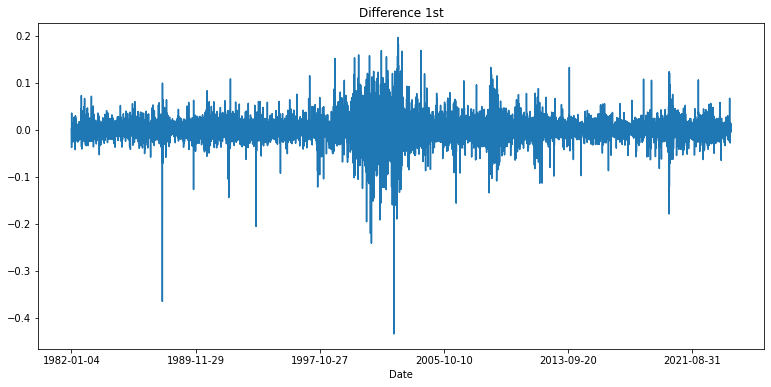

In [128]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

Results of Dickey=Fuller Test:
Test Statistic                   -29.705078
p-value                            0.000000
#Lags Used                        39.000000
Number of Observations Used    10586.000000
Critical Value (1%)               -3.430968
Critical Value (5%)               -2.861813
Critical Value (10%)              -2.566915
dtype: float64


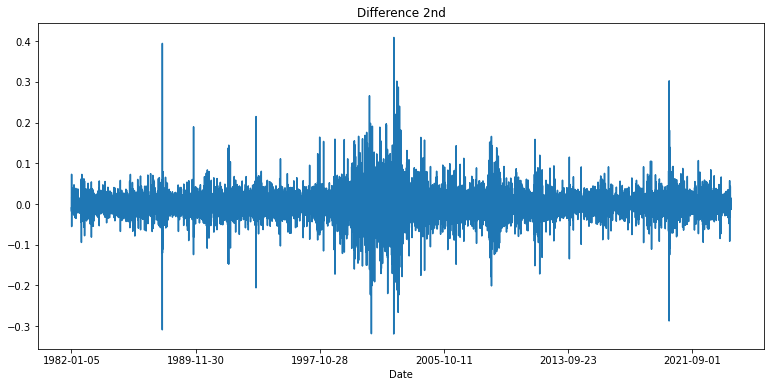

In [129]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

Results of Dickey=Fuller Test:
Test Statistic                   -36.952090
p-value                            0.000000
#Lags Used                        39.000000
Number of Observations Used    10585.000000
Critical Value (1%)               -3.430968
Critical Value (5%)               -2.861813
Critical Value (10%)              -2.566915
dtype: float64


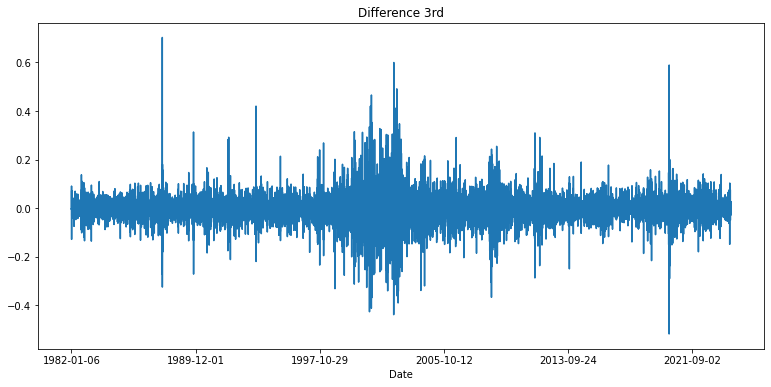

In [130]:
diff_3 = diff_2.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 3rd')

augmented_dickey_fuller_test(diff_3)

<AxesSubplot:title={'center':'Difference 3rd'}, xlabel='Date'>

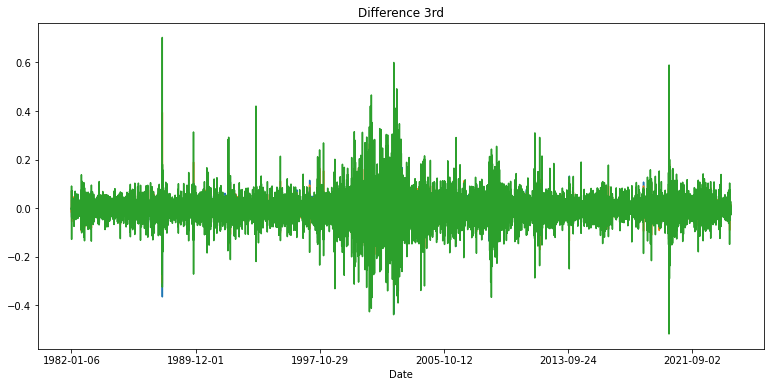

In [131]:
diff_1.plot(title='Difference 1st')
diff_2.plot(title='Difference 2nd')
diff_3.plot(title='Difference 3rd')


In [132]:
model = ARIMA(train_data, order=(2, 1, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 9565
Model:                 ARIMA(2, 1, 1)   Log Likelihood               21194.560
Date:                Thu, 29 Feb 2024   AIC                         -42381.119
Time:                        13:13:23   BIC                         -42352.456
Sample:                             0   HQIC                        -42371.395
                               - 9565                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8101      0.121      6.669      0.000       0.572       1.048
ar.L2         -0.0489      0.006     -8.026      0.000      -0.061      -0.037
ma.L1         -0.7620      0.121     -6.309      0.0

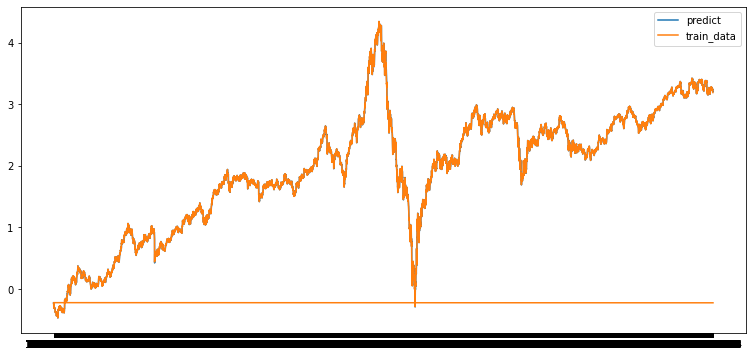

In [133]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given

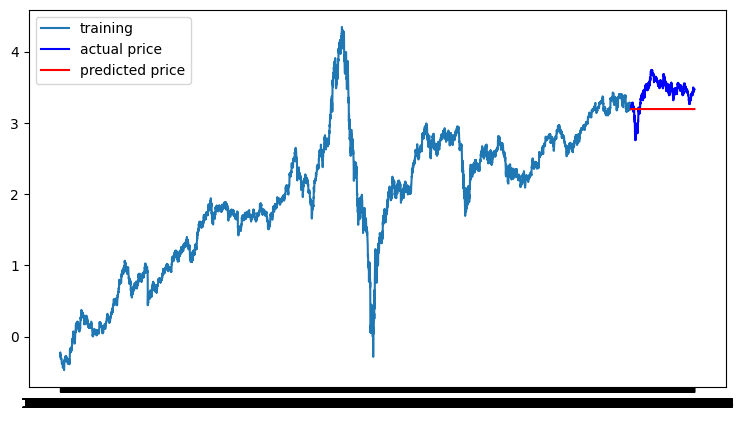

In [134]:
model = ARIMA(train_data, order=(2, 1, 1))  
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

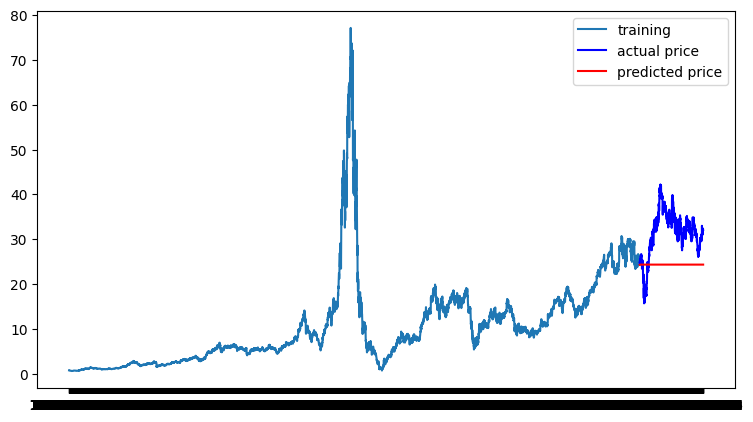

In [135]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [136]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  76.57339849027906
MAE:  7.878450201653566
RMSE:  8.750622748712177
MAPE: 24.10%


## 시스코


In [137]:
import yfinance as yf

# 삼성전자 주식 데이터 불러오기
cisco = yf.Ticker('CSCO')  



# 데이터 가져오기 (과거부터 오늘까지의 데이터)
cisco_data = cisco.history(period='max')


# 날짜 형식 변경 및 인덱스 설정
cisco_data.index = pd.to_datetime(cisco_data.index).strftime('%Y-%m-%d')

# 데이터프레임 생성
df = pd.DataFrame(cisco_data,  columns=cisco_data.columns)

df


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1990-02-16,0.000000,0.054600,0.050446,0.052820,940636800,0.0,0.0
1990-02-20,0.000000,0.054600,0.051039,0.054600,151862400,0.0,0.0
1990-02-21,0.000000,0.054007,0.051633,0.053413,70531200,0.0,0.0
1990-02-22,0.000000,0.055787,0.054007,0.054007,45216000,0.0,0.0
1990-02-23,0.000000,0.054600,0.053413,0.053710,44697600,0.0,0.0
...,...,...,...,...,...,...,...
2024-02-22,48.270000,48.700001,48.150002,48.570000,22020300,0.0,0.0
2024-02-23,48.619999,49.139999,48.500000,48.860001,13141600,0.0,0.0
2024-02-26,48.849998,48.900002,48.360001,48.400002,13018700,0.0,0.0


In [138]:
ts = df['Close']
ts

Date
1990-02-16     0.052820
1990-02-20     0.054600
1990-02-21     0.053413
1990-02-22     0.054007
1990-02-23     0.053710
                ...    
2024-02-22    48.570000
2024-02-23    48.860001
2024-02-26    48.400002
2024-02-27    48.310001
2024-02-28    48.060001
Name: Close, Length: 8572, dtype: float64

In [139]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

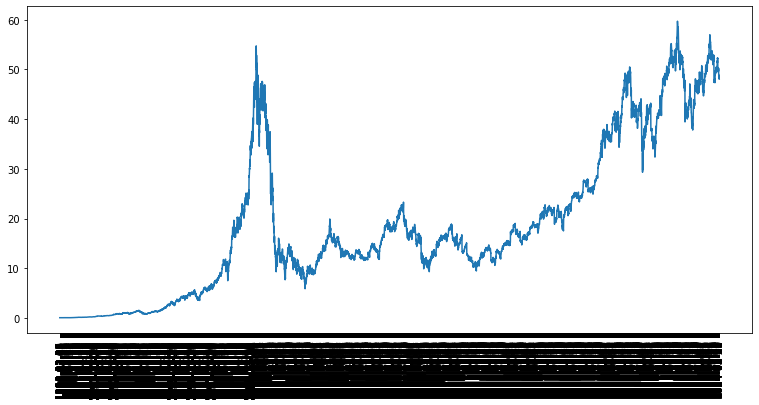

In [140]:
plt.plot(ts)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

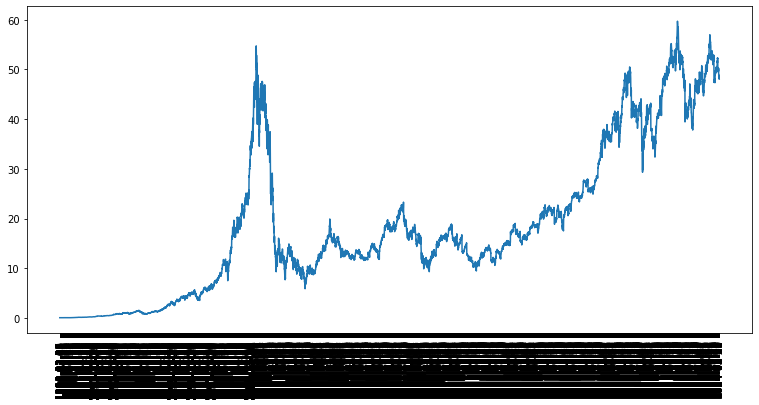

In [141]:
ts_log = np.log(ts)
plt.plot(ts)

# x 축 라벨 각도 조정
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

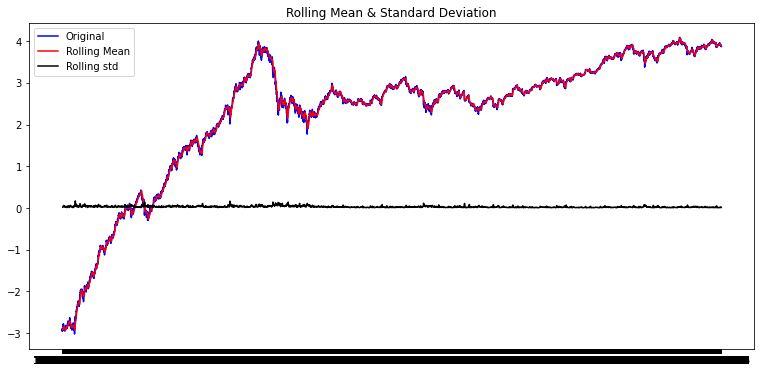

In [142]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

Results of Dickey=Fuller Test:
Test Statistic                   -4.448049
p-value                           0.000244
#Lags Used                       13.000000
Number of Observations Used    8558.000000
Critical Value (1%)              -3.431114
Critical Value (5%)              -2.861878
Critical Value (10%)             -2.566950
dtype: float64


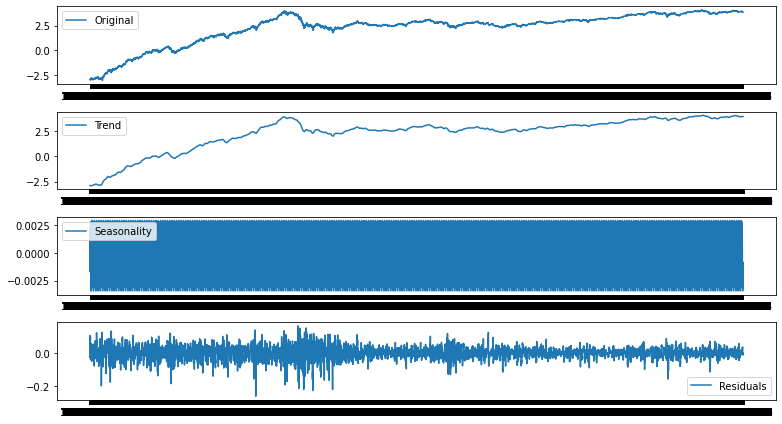

In [144]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

decomposition = seasonal_decompose(ts_log, model='additive', period = 30) 


plt.rcParams['figure.figsize'] = (11,6)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

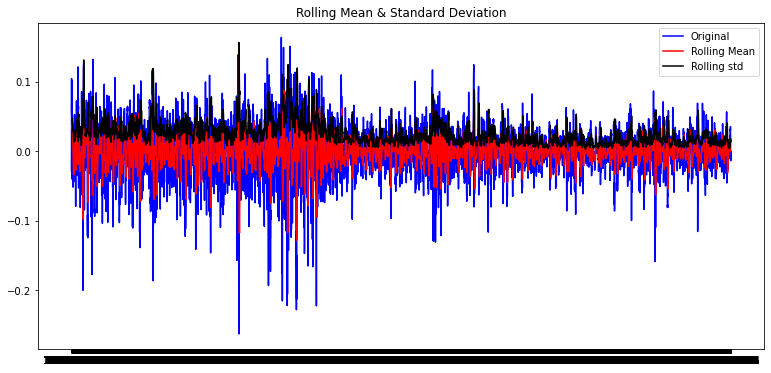

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

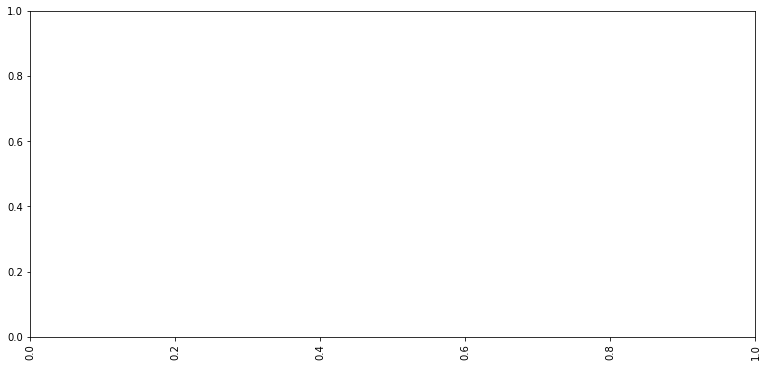

In [145]:
residual.dropna(inplace=True)
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)
plt.xticks(rotation=90)

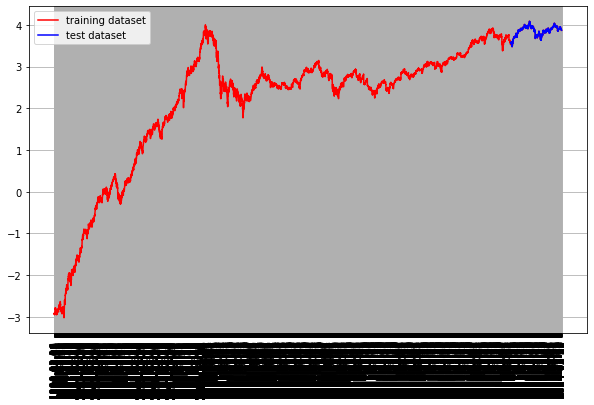

In [146]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.xticks(rotation=90)
plt.legend()

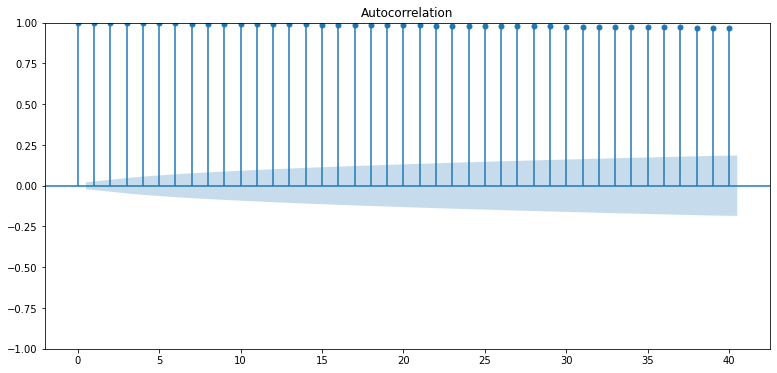

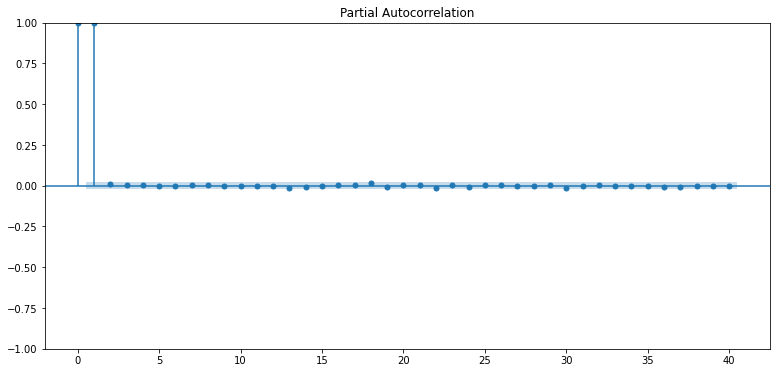

In [147]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey=Fuller Test:
Test Statistic                  -25.116047
p-value                           0.000000
#Lags Used                       12.000000
Number of Observations Used    8558.000000
Critical Value (1%)              -3.431114
Critical Value (5%)              -2.861878
Critical Value (10%)             -2.566950
dtype: float64


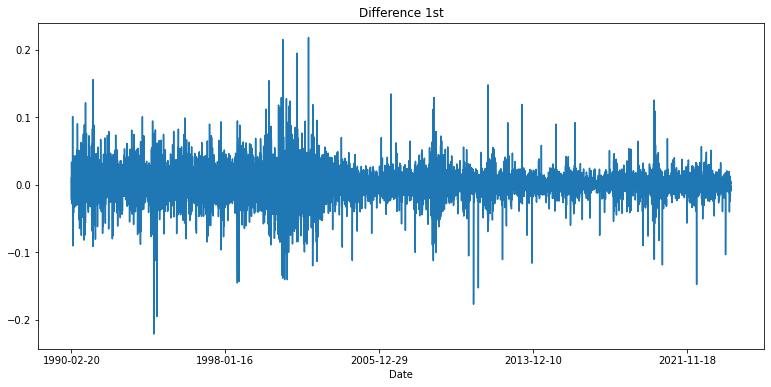

In [148]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

Results of Dickey=Fuller Test:
Test Statistic                  -26.178054
p-value                           0.000000
#Lags Used                       37.000000
Number of Observations Used    8532.000000
Critical Value (1%)              -3.431117
Critical Value (5%)              -2.861879
Critical Value (10%)             -2.566950
dtype: float64


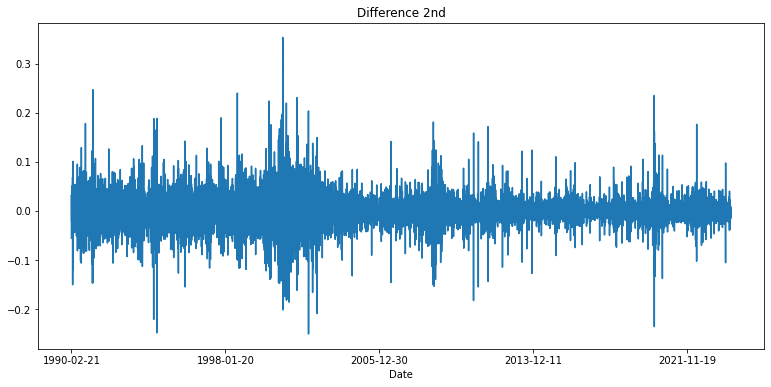

In [149]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

Results of Dickey=Fuller Test:
Test Statistic                  -34.042912
p-value                           0.000000
#Lags Used                       37.000000
Number of Observations Used    8531.000000
Critical Value (1%)              -3.431117
Critical Value (5%)              -2.861879
Critical Value (10%)             -2.566950
dtype: float64


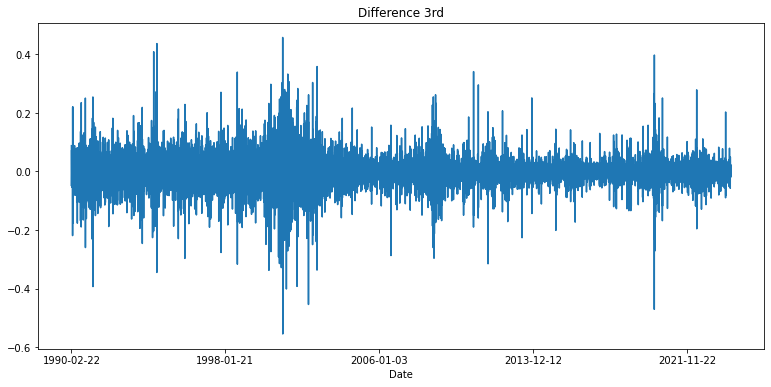

In [150]:
diff_3 = diff_2.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 3rd')

augmented_dickey_fuller_test(diff_3)

<AxesSubplot:title={'center':'Difference 3rd'}, xlabel='Date'>

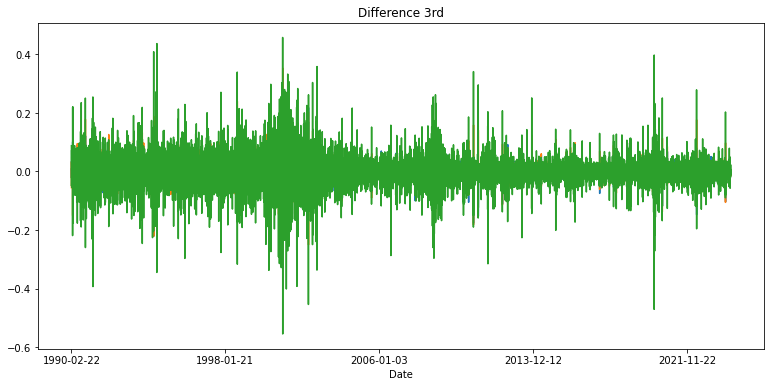

In [151]:
diff_1.plot(title='Difference 1st')
diff_2.plot(title='Difference 2nd')
diff_3.plot(title='Difference 3rd')


In [152]:
model = ARIMA(train_data, order=(5, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 7714
Model:                 ARIMA(5, 1, 0)   Log Likelihood               17243.849
Date:                Thu, 29 Feb 2024   AIC                         -34475.697
Time:                        13:49:42   BIC                         -34433.993
Sample:                             0   HQIC                        -34461.396
                               - 7714                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0315      0.008     -4.115      0.000      -0.046      -0.016
ar.L2         -0.0439      0.008     -5.819      0.000      -0.059      -0.029
ar.L3         -0.0143      0.008     -1.806      0.0

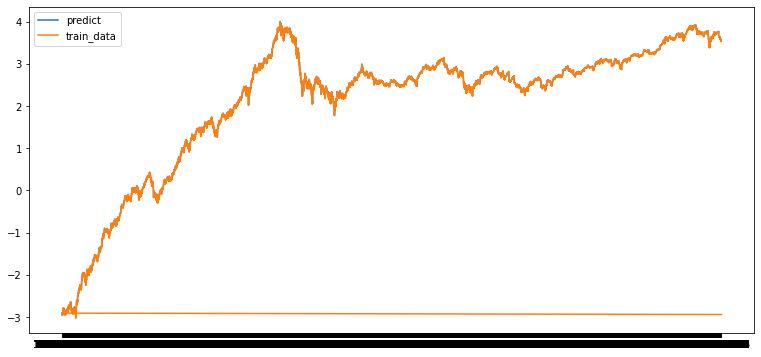

In [153]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given

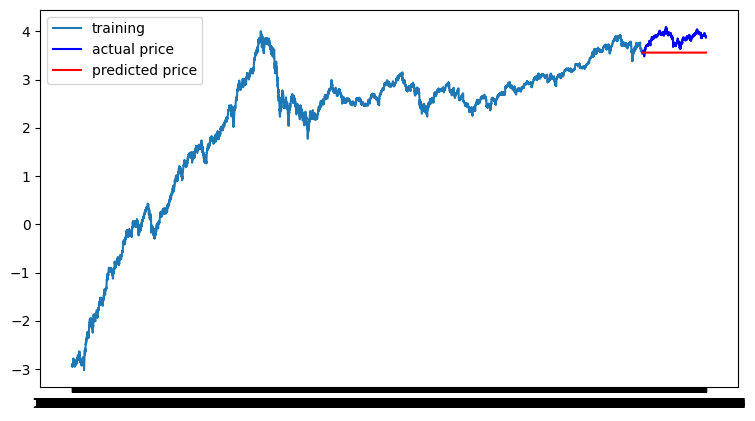

In [154]:
model = ARIMA(train_data, order=(5, 1, 0))  
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.5) # 95% conf
fc = np.array(fc)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

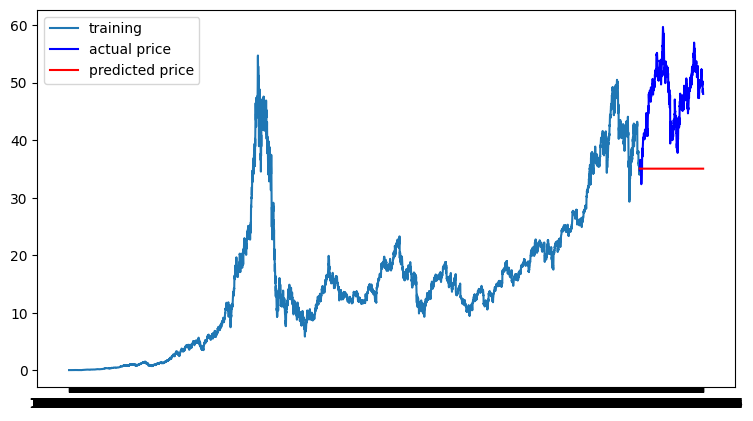

In [155]:
plt.figure(figsize=(9, 5), dpi=100)
plt.plot(np.exp(train_data), label='training')
plt.plot(np.exp(test_data), c='b', label='actual price')
plt.plot(np.exp(fc_series), c='r', label='predicted price')
plt.legend()
plt.show()

In [156]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  185.45865272772915
MAE:  12.607311644719639
RMSE:  13.618320481165405
MAPE: 25.53%


### 회고

시계열 데이터를 3일간 했는데 사실 제대로 이해는 못한거 같습니다.
